# HW 8 BDS4440

# Analyzing a data set: AMES IOWA Real Estate Data

Go to the Kaggle site: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
and download the AMES Iowa data set

In [31]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
train = pd.read_csv('data/train.csv')
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

# Problem 1

* Use the results of problems 6 to drop the useless categorical features from the train set (anova test)
* Out of these remaining categorical features, dummify them and give them a name.
* Remove the old categorical features, and replace them with the dummified ones.
* Besure to convert the sale price into a normal distribution using the function `np.log1p`. 
* Remember to drop the last dummy column and concatenate them to the rest of the data set.
* You should have 261 features if you did it correctly.

In [32]:
categorical = ['Id']
numerical = []
target='SalePrice'
for i in train.columns:
    if i in [target,'Id']:
        pass
    elif train[i].dtype=='O':
        categorical.append(i)
    else:
        numerical.append(i)
        
from scipy.stats import f,f_oneway
def one_way_anova(*data,alpha):
    dfn = 0
    for j in data:
        dfn=dfn+1
    n_groups = dfn
    dfn = dfn-1
    total_elements = len([item for sublist in data for item in sublist]) #flatten data
    dfd = total_elements-n_groups
    F_stat,p_value = f_oneway(*data) #data is input as a list of lists
    F_critical = f.ppf(1-alpha,dfn,dfd)
    #print('F_critical: {}, alpha: {}'.format(F_critical,alpha))
    if F_stat>F_critical and p_value<alpha:
        return 'Reject Null hypothesis with F_stat:{} & P_value:{}'.format(F_stat,p_value)
    else:
        return 'Fail to Reject Null hypothesis with F_stat:{} & P_value:{}'.format(F_stat,p_value)
    
    
import numpy as np
target='SalePrice'
train[target] = np.log1p(train[target])
useless_categorical_features = []
for col in categorical:
    data = train[[col,target]].groupby(col)[target].agg(lambda x: list(x))
    test = one_way_anova(*data,alpha=0.01)
    if 'Fail' in test:
        useless_categorical_features.append(col)
print(useless_categorical_features)

train.drop(useless_categorical_features,axis=1,inplace=True)

categorical2 = [j for j in train.columns if j not in numerical and j!=target]

df = pd.DataFrame()
for c in categorical2:
    d = pd.get_dummies(train[c])
    d.columns = [c+'_'+str(j) for j in d.columns]
    df = pd.concat([df,d],axis=1)

    
train = train.drop(categorical2,axis=1)
train = pd.concat([train,df],axis=1)
train.head()

['Id', 'Street', 'Utilities', 'LandSlope', 'Condition2', 'BsmtFinType2', 'PoolQC', 'MiscFeature']


MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          60         65.0     8450            7            5       2003   
1          20         80.0     9600            6            8       1976   
2          60         68.0    11250            7            5       2001   
3          70         60.0     9550            7            5       1915   
4          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2          ...            \
0          2003       196.0         706           0          ...             
1          1976         0.0         978           0          ...             
2          2002       162.0         486           0          ...             
3          1970         0.0         216           0          ...             
4          2000       350.0         655           0          ...             

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0               0             0             0            1   
1               0             0             0            1   
2               0             0             0            1   
3               0             0             0            1   
4               0             0             0            1   

   SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                      0                      0                     0   
1                      0                      0                     0   
2                      0                      0                     0   
3                      1                      0                     0   
4                      0                      0                     0   

   SaleCondition_Family  SaleCondition_Normal  SaleCondition_Partial  
0                     0                     1                      0  
1                     0                     1                      0  
2                     0                     1                      0  
3                     0                     0                      0  
4                     0                     1                      0  

[5 rows x 261 columns]

# Problem 3 Complete the code the impute the mean values of the numerical columns and zero for the nulls in the remaining categorical columns.

In [34]:
for n in numerical:
    mean = train[n].mean()
    train[n]=train[n].fillna(mean)
for col in [j for j in train.columns if j not in numerical]:
    train[col]=train[col].fillna(0)

# Problem 4: 

Complete the code to find the cumulative explained variance ratio, and plot it on a graph. How many components do you need?

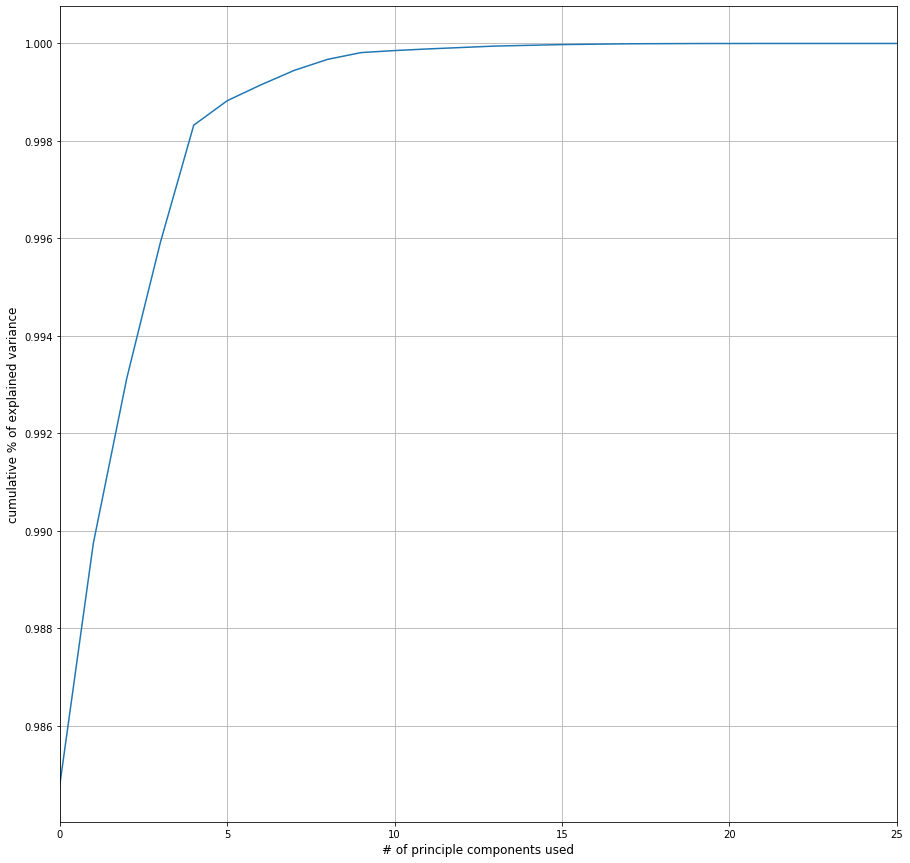

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA()
X_pca = train.drop(target,axis=1)
train_reduced = pca.fit_transform(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(15,15))
plt.plot(range(X.shape[1]),cumsum)
plt.xlabel('# of principle components used',fontsize=12)
plt.ylabel('cumulative % of explained variance',fontsize=12)
plt.xlim(0,25)
plt.grid()
plt.show()

# Do problem 15.1 (ch 15, problem 1)